In [ ]:
# Install required packages
!pip install timm faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Import libraries
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import timm
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors


In [ ]:
# Load first 10,000 samples from CIFAR-100
def load_cifar100_subset(sample_size=10000):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)

    # Use the first `sample_size` samples
    indices = list(range(sample_size))
    subset = Subset(dataset, indices)
    dataloader = DataLoader(subset, batch_size=64, shuffle=False, num_workers=2)
    return subset, dataloader

In [ ]:
# Load Pretrained Swin Transformer Model
def get_swin_transformer():
    model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
    model.head = torch.nn.Identity()  # Remove the classification head
    model.eval()
    return model

In [ ]:
# Extract Feature Vectors and Labels
def extract_features(model, dataloader, device="cuda"):
    model = model.to(device)
    features, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.extend(targets.numpy())
    return np.vstack(features), np.array(labels)

In [ ]:
# Build FAISS Index
def build_faiss_index(features):
    features = features.reshape(features.shape[0], -1)  # Reshape to 2D
    d = features.shape[1]  # Feature dimension
    index = faiss.IndexFlatL2(d)  # L2 distance-based index
    index.add(features)  # Add dataset features to the index
    return index

In [ ]:
# Retrieve similar images using FAISS
def retrieve_similar_images_faiss(query_features, index, k=5):
    distances, indices = index.search(query_features, k)  # Retrieve top-k matches
    return indices, distances

In [ ]:
def visualize_retrieval(query_idx, retrieved_indices, dataset, title, k):
    # Safely access class names if dataset is a Subset
    class_names = dataset.dataset.classes if isinstance(dataset, torch.utils.data.Subset) else dataset.classes

    query_img, query_label = dataset[query_idx]
    fig, axes = plt.subplots(1, k + 1, figsize=(3 * (k + 1), 4))
    axes[0].imshow((query_img.permute(1, 2, 0).numpy() * 0.229 + 0.485).clip(0, 1))
    axes[0].set_title(f"Query\n({class_names[query_label]})")
    axes[0].axis("off")

    # Iterate through the first row of retrieved_indices (FAISS returns a 2D array)
    for i, idx in enumerate(retrieved_indices[0][:k]): # Change here to access the first row
        img, label = dataset[idx]
        img = (img.permute(1, 2, 0).numpy() * 0.229 + 0.485).clip(0, 1)
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"Top-{i + 1}\n({class_names[label]})")
        axes[i + 1].axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
# Compute Retrieval Metrics
def compute_metrics(retrieved_indices, query_labels, database_labels):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_relevant = 0
    total_non_relevant = 0

    for i in range(len(query_labels)):
        retrieved_labels = database_labels[retrieved_indices[i]]
        relevant_items = set(np.where(database_labels == query_labels[i])[0])
        retrieved_set = set(retrieved_indices[i])
        non_relevant_items = set(np.where(database_labels != query_labels[i])[0])

        tp = len(retrieved_set & relevant_items)
        fp = len(retrieved_set & non_relevant_items)
        fn = len(relevant_items - retrieved_set)

        true_positives += tp
        false_positives += fp
        false_negatives += fn
        total_relevant += len(relevant_items)
        total_non_relevant += len(non_relevant_items)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    false_positive_rate = false_positives / total_non_relevant if total_non_relevant > 0 else 0

    return precision, false_positive_rate

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset, dataloader = load_cifar100_subset()
model = get_swin_transformer()

# Extract features and labels
features, labels = extract_features(model, dataloader, device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
# Build FAISS index
faiss_index = build_faiss_index(features)

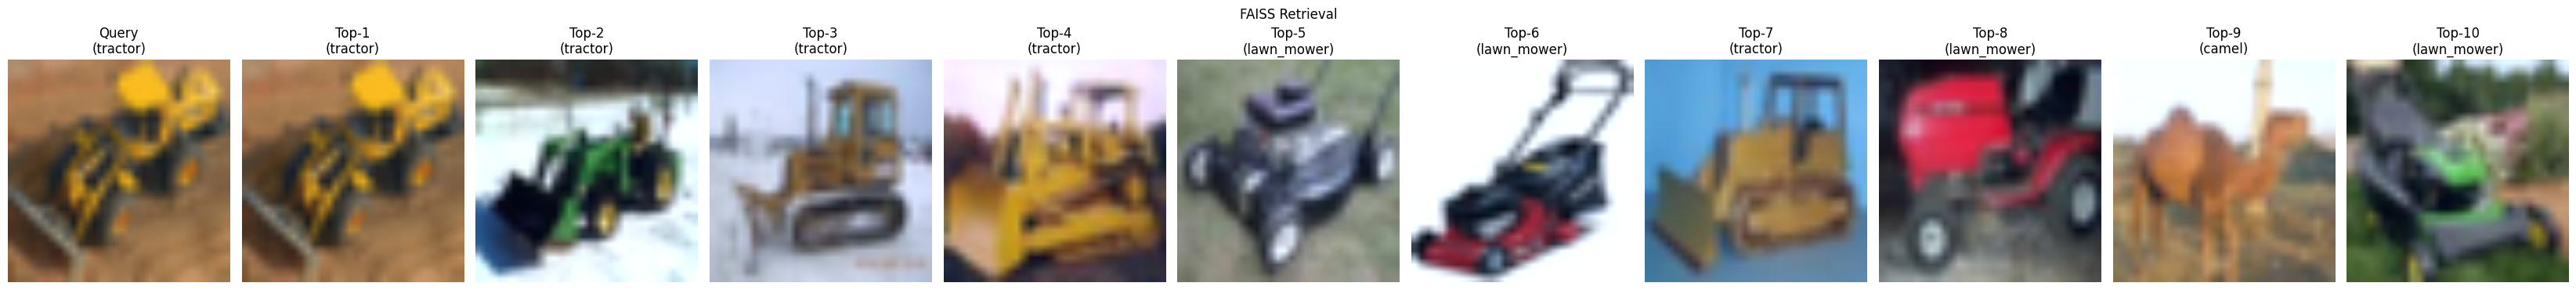

(0.5, 0.000505356781888013)

In [ ]:
# Select a random query image
query_idx = np.random.randint(len(dataset))
query_image, query_label = dataset[query_idx]
query_image = query_image.unsqueeze(0).to(device)
query_features = model(query_image).cpu().detach().numpy().reshape(1, -1)

# Retrieve similar images
k = 10  # Number of top matches to retrieve
faiss_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k=k)
# Select a random query image
query_idx = 3330
query_image, query_label = dataset[query_idx]
query_image = query_image.unsqueeze(0).to(device)
query_features = model(query_image).cpu().detach().numpy().reshape(1, -1)

# Retrieve similar images
k = 10  # Number of top matches to retrieve
faiss_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k=k)

# Visualize retrieval results
visualize_retrieval(query_idx, faiss_indices, dataset, title="FAISS Retrieval", k=k)
compute_metrics(faiss_indices, [query_label], labels)

In [ ]:
def calculate_precision_at_k(retrieved_indices, query_label, database_labels, k):
    """Calculates precision@k for a single query.

    Args:
        retrieved_indices: Indices of the retrieved images.
        query_label: Label of the query image.
        database_labels: Labels of all images in the database.
        k: The value of k for precision@k.

    Returns:
        The precision@k value.
    """
    retrieved_labels = database_labels[retrieved_indices[0][:k]]  # Access the first row and top k
    relevant_count = np.sum(retrieved_labels == query_label)
    return relevant_count / k

# Example usage for 5 query images and multiple k values
query_indices = [300, 10, 3330, 1024, 5789]
k_values = [10, 20, 30, 40, 50]

precision_table = {}

for query_idx in query_indices:
    query_image, query_label = dataset[query_idx]
    query_image = query_image.unsqueeze(0).to(device)
    query_features = model(query_image).cpu().detach().numpy().reshape(1, -1)

    faiss_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k=max(k_values))

    precision_table[query_idx] = {}
    for k in k_values:
        precision = calculate_precision_at_k(faiss_indices, query_label, labels, k)
        precision_table[query_idx][k] = precision

# Print the precision table
print("Precision Table:")
for query_idx, precisions in precision_table.items():
  print(f"Query Image Index: {query_idx}")
  for k, precision in precisions.items():
      print(f"  Precision@{k}: {precision:.4f}")


Precision Table:
Query Image Index: 300
  Precision@10: 0.1000
  Precision@20: 0.0500
  Precision@30: 0.0333
  Precision@40: 0.0750
  Precision@50: 0.0600
Query Image Index: 10
  Precision@10: 1.0000
  Precision@20: 1.0000
  Precision@30: 1.0000
  Precision@40: 0.9000
  Precision@50: 0.8000
Query Image Index: 3330
  Precision@10: 0.5000
  Precision@20: 0.4000
  Precision@30: 0.3333
  Precision@40: 0.3500
  Precision@50: 0.3400
Query Image Index: 1024
  Precision@10: 1.0000
  Precision@20: 0.9500
  Precision@30: 0.8667
  Precision@40: 0.9000
  Precision@50: 0.8600
Query Image Index: 5789
  Precision@10: 0.9000
  Precision@20: 0.7000
  Precision@30: 0.6333
  Precision@40: 0.6250
  Precision@50: 0.5600
